We are going to use this notebook to summarize the quality of tested architectures during the first exploration phase in our hyperparameter optimizion (HPO) pipeline.

Since we don't know which network hyperparameters (e.g., number of layer/attention heads, embedding dimension, etc.) works best for this problem, we'll follow an **hierarchical search**:
1. Coarse manual exploration to find good regions of these hyperparameters' seach space.
2. Fine-grained automated HPO using NNI around the regions selected in the first step.

This script analyses the data generated in the first step described above, where the model were generated with increasing complexity. With this we are effectively building an empirical scaling curve (performance vs. capacity), which gives intuition about whether the architecture is under- or over-capacity before we even tune training hyperparameters.

We use 10 seeds for parameter initialization (for each architecture tried), which gives a small but meaningful estimate of performance variance due to initialization.

In [21]:
import os, sys, re
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.utils.model_handling import get_models_evaluation_data

In [22]:
dir = 'models_baseline_2'

In [23]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))
models = os.listdir(os.path.join(project_root, 'results', dir))

# Rewards per environment seed (per model)

In [24]:
data = {}
for model_id in models:
    data[model_id] = {}

    # get evaluation .pkl
    eval_data = get_models_evaluation_data(model_id=model_id, model_dir=dir)

    for env_info, eval_data in eval_data.items():
        env_seed = int(re.findall(r'\d+', env_info)[0])
        data[model_id][env_seed] = np.round(eval_data, 2)

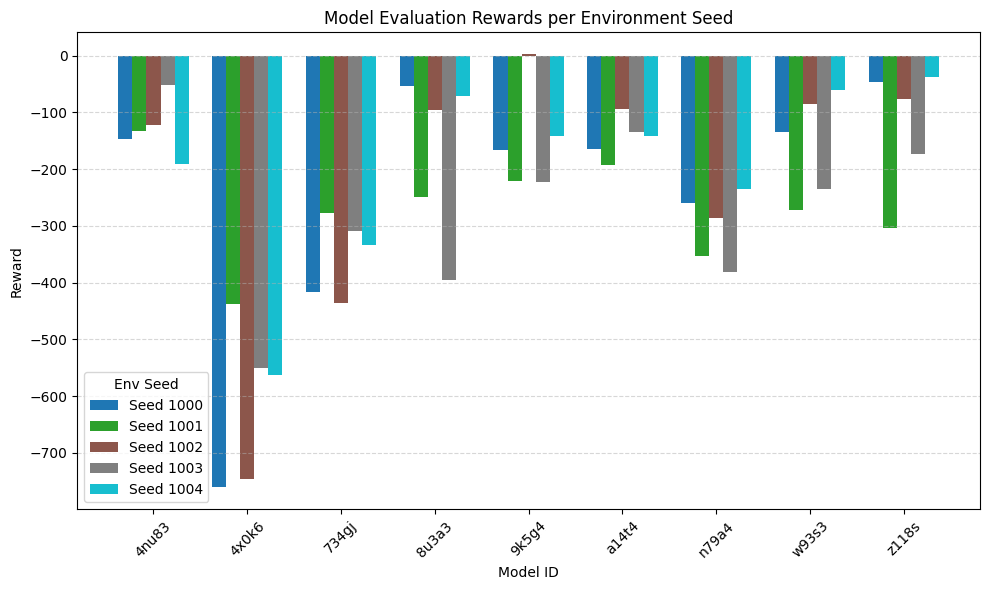

In [25]:
# Extract keys
models = list(data.keys())
env_seeds = sorted(next(iter(data.values())).keys())  # e.g. [1000, 1001, 1002, 1003, 1004]

# Group bar plot setup
x = np.arange(len(models))
bar_width = 0.15
colors = plt.cm.tab10(np.linspace(0, 1, len(env_seeds)))

plt.figure(figsize=(10, 6))

# Plot one bar per env seed
for i, seed in enumerate(env_seeds):
    rewards = [data[m][seed] for m in models]
    plt.bar(x + i * bar_width, rewards, width=bar_width, label=f"Seed {seed}", color=colors[i])

# Formatting
plt.xticks(x + bar_width * (len(env_seeds) - 1) / 2, models, rotation=45)
plt.xlabel("Model ID")
plt.ylabel("Reward")
plt.title("Model Evaluation Rewards per Environment Seed")
plt.legend(title="Env Seed")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# Mean and standard deviation per environment seed

In [26]:
# Initialize stats dict
stats = {seed: [] for seed in env_seeds}

# Aggregate rewards by seed
for model_vals in data.values():
    for seed, reward in model_vals.items():
        stats[seed].append(float(reward))  # cast np.float64 to float if needed

# Compute mean and std per seed
seed_means = {seed: np.mean(vals) for seed, vals in stats.items()}
seed_stds  = {seed: np.std(vals)  for seed, vals in stats.items()}

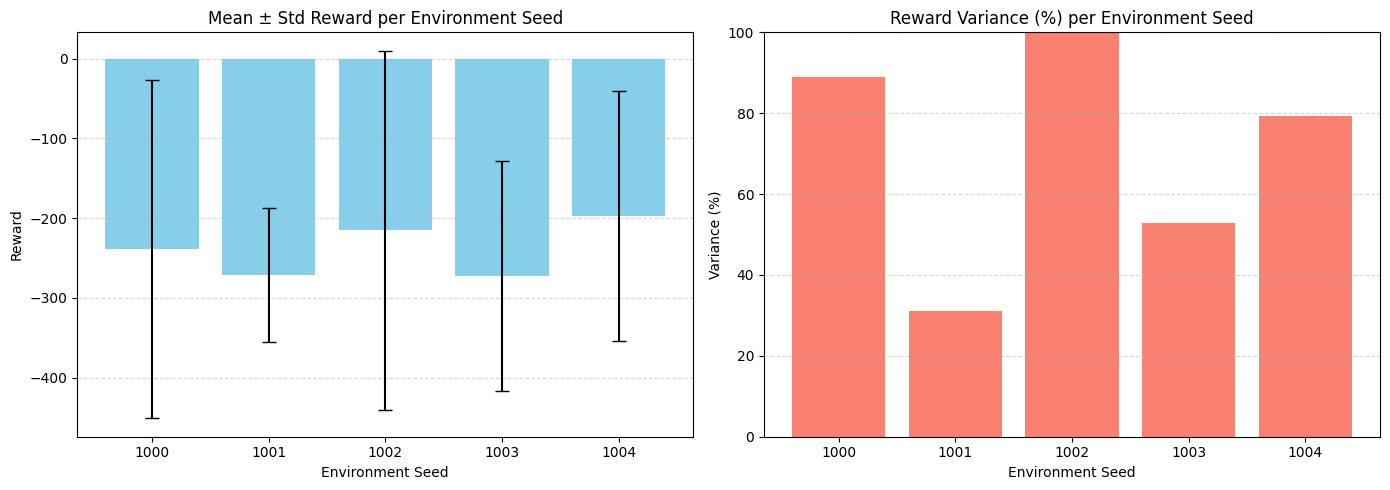

In [27]:
# Sort seeds for consistent x-axis
seeds = sorted(seed_means.keys())
means = [seed_means[s] for s in seeds]
stds  = [seed_stds[s] for s in seeds]

# Compute variance percentage
var_pct = [(std / abs(mean)) * 100 if mean != 0 else 0 for mean, std in zip(means, stds)]

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Mean ± Std
axes[0].bar(seeds, means, yerr=stds, capsize=5, color='skyblue')
axes[0].set_xlabel("Environment Seed")
axes[0].set_ylabel("Reward")
axes[0].set_title("Mean ± Std Reward per Environment Seed")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Right plot: Variance percentage
axes[1].bar(seeds, var_pct, color='salmon')
axes[1].set_xlabel("Environment Seed")
axes[1].set_ylabel("Variance (%)")
axes[1].set_title("Reward Variance (%) per Environment Seed")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Top 3 models (and top 3 environment seeds)

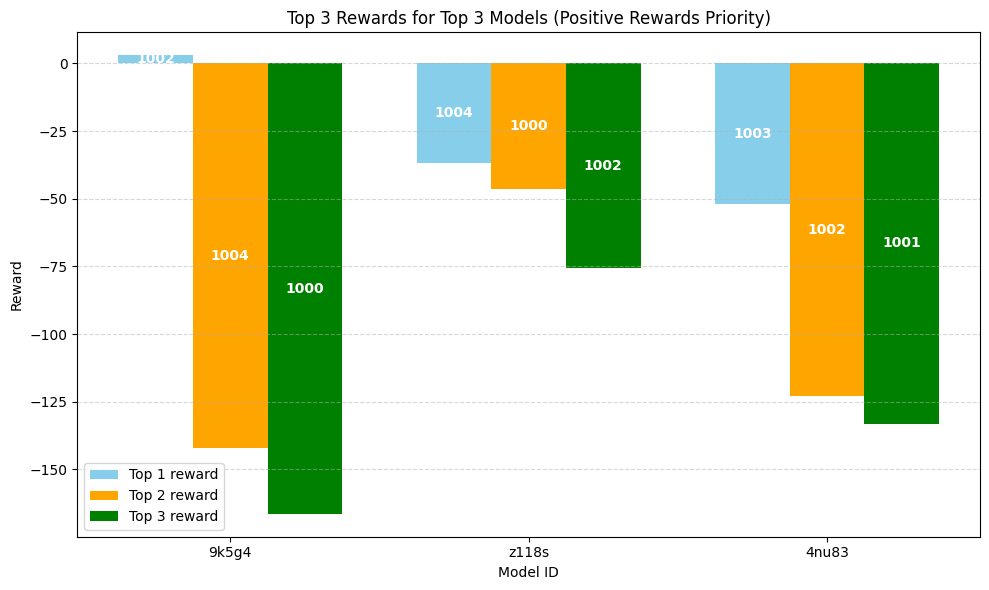

In [28]:
# Compute metrics per model
model_metrics = {}
for model, rewards_dict in data.items():
    rewards = np.array(list(rewards_dict.values()))
    num_positive = np.sum(rewards > 0)
    avg_reward = np.mean(rewards)
    model_metrics[model] = (num_positive, avg_reward)

# Sort models: first by number of positive rewards (desc), then by avg_reward (desc)
sorted_models = sorted(model_metrics.keys(),
                       key=lambda m: (-model_metrics[m][0], -model_metrics[m][1]))

# Take top 3 models
top_models = sorted_models[:3]

# Prepare top 3 rewards per model with their seeds
top_rewards = []
top_seeds = []
for model in top_models:
    rewards_dict = data[model]
    # Sort rewards descending and keep seeds
    sorted_rewards = sorted(rewards_dict.items(), key=lambda x: x[1], reverse=True)[:3]
    top_seeds.append([seed for seed, _ in sorted_rewards])
    top_rewards.append([reward for _, reward in sorted_rewards])

# Plot
x = np.arange(len(top_models))
bar_width = 0.25
colors = ['skyblue', 'orange', 'green']

plt.figure(figsize=(10, 6))

for i in range(3):
    rewards = [r[i] for r in top_rewards]
    bars = plt.bar(x + i * bar_width, rewards, width=bar_width, color=colors[i], label=f"Top {i+1} reward")
    
    # Annotate bars with env seed
    for bar, seed in zip(bars, [s[i] for s in top_seeds]):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2,
                 height / 2 if height >= 0 else height / 2,
                 str(seed), ha='center', va='center', color='white', fontweight='bold')

plt.xticks(x + bar_width, top_models)
plt.xlabel("Model ID")
plt.ylabel("Reward")
plt.title("Top 3 Rewards for Top 3 Models (Positive Rewards Priority)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()